In [1]:
!makeblastdb -in ../data/Bpl.maker_FilteredModels_proteins_v1.0.fasta \
             -dbtype prot \
             -out data/Bpl_proteome_db




Building a new DB, current time: 12/11/2025 09:08:02
New DB name:   /home/likewise-open/ADS/oakley/labdata/users/Oakley/GitHub/scripts/notebooks/data/Bpl_proteome_db
New DB title:  ../data/Bpl.maker_FilteredModels_proteins_v1.0.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 33584 sequences in 1.10476 seconds.




In [2]:
query = """>XP_052069431.1 rhodopsin, GQ-coupled-like [Mytilus californianus]
MSGTSASPDNATSIPFNGTTSVYDTYGYFIHPHWKQFPVVPDEYHYMVGIYITFVGITGIIGNSIVIWIF
STTKNLKTPSNMLIMNLALSDLVFSAVNGFPLLTISAFNRKWMWGDAACQLYGFIGGLFGLMSIITLAAI
SIDRYYNIAEPLKAAQFMTRRKAFMMIVLVWIWSLVWAVPPIFGWGAYVPEGFQTSCTFDYISTEPHMRA
YMIGMYIGGFVLPLVMIIVSYVLIWKAIRKHENEMLSMAKKMKIEDIRNNQEKANAEVRIAKIAMIIVLL
YLLSWSPYATVALIAQFGPAEWVTPYVSELPVMLAKAAAMHNPIVYAFSHPRFRQALHKRVPWLLCCCDV
TPARSASTSHSKVTTKRQVSRQVSNDSYYDGRADSDVSSCISQIDDYGQSIEMKKTVSDTSFTRRSNKKA
VKGSPMGSPDSEDIVRELIQALVSVSHRPPAVQPQYTPNIPPQNNLQNPDNAQKGVYVIDNGKQIDMATY
LSHLVATGRNSDTVTKNPTPNLPIVKQNIDNTDESVKANEKKAHQDKQIDVQKGHGKDKDTGNQQTRDSS
SDEGNSSKVCYSNQAYDKGADDNDKSTIIDDGHV
"""

with open("opsin_query.fa", "w") as f:
    f.write(query)

print("Query FASTA written to opsin_query.fa")


Query FASTA written to opsin_query.fa


In [3]:
!blastp \
  -query opsin_query.fa \
  -db data/Bpl_proteome_db \
  -evalue 1e-5 \
  -max_target_seqs 20 \
  -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore" \
  -out opsin_vs_Bpl.tsv

print("BLAST search finished. Results saved to opsin_vs_Bpl.tsv")


BLAST search finished. Results saved to opsin_vs_Bpl.tsv


In [4]:
!head opsin_vs_Bpl.tsv


XP_052069431.1	Bpl_scaf_38266-2.5	67.009	585	178	8	4	587	1	571	0.0	790
XP_052069431.1	Bpl_scaf_38266-1.1	56.522	391	133	7	118	501	11	371	3.57e-136	416
XP_052069431.1	Bpl_scaf_38266-1.1	53.247	385	146	7	119	501	443	795	4.80e-121	376
XP_052069431.1	Bpl_scaf_38266-1.1	57.895	38	14	1	16	51	416	453	1.95e-07	53.9
XP_052069431.1	Bpl_scaf_19671-4.8	34.432	273	162	4	117	385	2	261	5.04e-47	166
XP_052069431.1	Bpl_scaf_64903-1.9	26.912	353	225	7	41	390	24	346	4.21e-35	135
XP_052069431.1	Bpl_scaf_10550-3.6	25.610	328	207	5	47	338	35	361	2.98e-31	126
XP_052069431.1	Bpl_scaf_57877-0.0	25.574	305	197	9	46	339	38	323	5.98e-27	113
XP_052069431.1	Bpl_scaf_64903-1.7	31.658	199	133	3	41	238	24	220	7.90e-27	109
XP_052069431.1	Bpl_scaf_39839-0.1	25.000	304	200	8	46	339	66	351	1.13e-26	112


In [6]:
import pandas as pd

# Read BLAST hits
cols = ["qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"]
df = pd.read_csv("opsin_vs_Bpl.tsv", sep="\t", names=cols)

# Identify strong candidates (>=45% identity and length >200 aa)
candidates = df[(df["pident"] >= 45) & (df["length"] > 200)]["sseqid"].unique().tolist()

print("Strong opsin-like candidates:", candidates)

# Extract sequences
from Bio import SeqIO

proteome = "../data/Bpl.maker_FilteredModels_proteins_v1.0.fasta"
records = SeqIO.to_dict(SeqIO.parse(proteome, "fasta"))

with open("Bpl_opsins.fa", "w") as out:
    for cid in candidates:
        if cid in records:
            SeqIO.write(records[cid], out, "fasta")
        else:
            print("WARNING: ID not found in proteome:", cid)

print("Extracted sequences written to Bpl_opsins.fa")


Strong opsin-like candidates: ['Bpl_scaf_38266-2.5', 'Bpl_scaf_38266-1.1']
Extracted sequences written to Bpl_opsins.fa


In [7]:
from Bio import SeqIO

for rec in SeqIO.parse("Bpl_opsins.fa", "fasta"):
    print(rec.id, "length:", len(rec.seq))


Bpl_scaf_38266-2.5 length: 571
Bpl_scaf_38266-1.1 length: 806


In [12]:
from Bio import Entrez, SeqIO

# Always set your email for NCBI
Entrez.email = "your_email@ucsb.edu"  # <-- change this

# 1. Search for bivalve opsin proteins
search_term = "opsin[Title] AND Bivalvia[Organism] AND srcdb_refseq[PROP]"
handle = Entrez.esearch(db="protein", term=search_term, retmax=30)
record = Entrez.read(handle)
handle.close()

ids = record["IdList"]
print(f"Found {len(ids)} protein IDs")

# 2. Fetch the corresponding protein sequences
if ids:
    handle = Entrez.efetch(db="protein", id=",".join(ids), rettype="fasta", retmode="text")
    seqs = list(SeqIO.parse(handle, "fasta"))
    handle.close()

    print(f"Fetched {len(seqs)} sequences")

    # 3. Write to a FASTA file
    with open("bivalve_opsins.fa", "w") as out:
        for rec in seqs:
            SeqIO.write(rec, out, "fasta")

    print("Wrote bivalve_opsins.fa")
else:
    print("No IDs found for this query.")


Found 9 protein IDs
Fetched 9 sequences
Wrote bivalve_opsins.fa


In [13]:
from Bio import SeqIO

final_list = []

# Load Mytilus + Bathymodiolus opsins
final_list.extend(list(SeqIO.parse("opsins_for_alignment.fa", "fasta")))

# Load the bivalve opsins we fetched from NCBI
final_list.extend(list(SeqIO.parse("bivalve_opsins.fa", "fasta")))

print(f"Total sequences in combined dataset: {len(final_list)}")

# Write unified FASTA
with open("all_bivalve_opsins.fa", "w") as out:
    SeqIO.write(final_list, out, "fasta")

print("Wrote all_bivalve_opsins.fa")
!mafft --auto all_bivalve_opsins.fa > all_bivalve_opsins_aligned.fa


Total sequences in combined dataset: 12
Wrote all_bivalve_opsins.fa
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.526
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 12
done.

Progressive alignment ... 
STEP    11 /11 
done.
tbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   10 / 12
Segment   1/  1    1-1187
STEP 005-007-1  rejected..    identical.    rejected. accepted. accepted. accepted. accepted. identical.    rejected. accepted. accepted. id

In [16]:
from Bio import SeqIO
import re

def clean_header(rec):
    desc = rec.description

    # bathymodiolus special case (no species text in header)
    if rec.id.startswith("Bpl_scaf"):
        species = "Bathymodiolus_sp"
        new_id = f"{species}_{rec.id}"
        return new_id

    # extract species name from NCBI description if present
    m = re.search(r"\[(.*?)\]", desc)
    if m:
        species = m.group(1).replace(" ", "_")
    else:
        species = "Unknown_sp"

    # Build ID: SpeciesName_Accession
    new_id = f"{species}_{rec.id}"
    # sanitize
    new_id = new_id.replace(":", "_").replace(".", "_")
    return new_id

renamed = []
for rec in SeqIO.parse("all_bivalve_opsins.fa", "fasta"):
    new_id = clean_header(rec)
    rec.id = new_id
    rec.description = ""
    renamed.append(rec)

with open("all_bivalve_opsins_renamed.fa", "w") as out:
    SeqIO.write(renamed, out, "fasta")

print("Wrote all_bivalve_opsins_renamed.fa with cleaned headers.")


Wrote all_bivalve_opsins_renamed.fa with cleaned headers.


In [17]:
!mafft --auto all_bivalve_opsins_renamed.fa > all_bivalve_opsins_renamed_aligned.fa



outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.526
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 12
done.

Progressive alignment ... 
STEP    11 /11 
done.
tbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   10 / 12
Segment   1/  1    1-1187
STEP 005-007-1  rejected..    rejected. accepted. rejected. accepted. accepted. identical.    identical.    rejected. accepted. accepted. identical.    rejected. rejected. accepted. identical.    accepted. id

In [18]:
!iqtree2 \
  -s all_bivalve_opsins_renamed_aligned.fa \
  -st AA \
  -m LG+G4 \
  -nt AUTO \
  -pre bivalve_opsins_cleaned


IQ-TREE multicore version 2.1.2 COVID-edition for Linux 64-bit built Oct 22 2020
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    osiris (AVX, 62 GB RAM)
Command: iqtree2 -s all_bivalve_opsins_renamed_aligned.fa -st AA -m LG+G4 -nt AUTO -pre bivalve_opsins_cleaned
Seed:    105066 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Thu Dec 11 09:40:33 2025
Kernel:  AVX - auto-detect threads (16 CPU cores detected)

Reading alignment file all_bivalve_opsins_renamed_aligned.fa ... Fasta format detected
Alignment most likely contains protein sequences
Alignment has 12 sequences with 1177 columns, 750 distinct patterns
401 parsimony-informative, 256 singleton sites, 520 constant sites
                                        Gap/Ambiguity  Composition  p-value
   1  Mytilus_californianus_XP_052069431_1     49.53%    failed      1.68%
   2  Bathymodiolus_sp_Bpl_scaf_38266-2.5      51.49%  

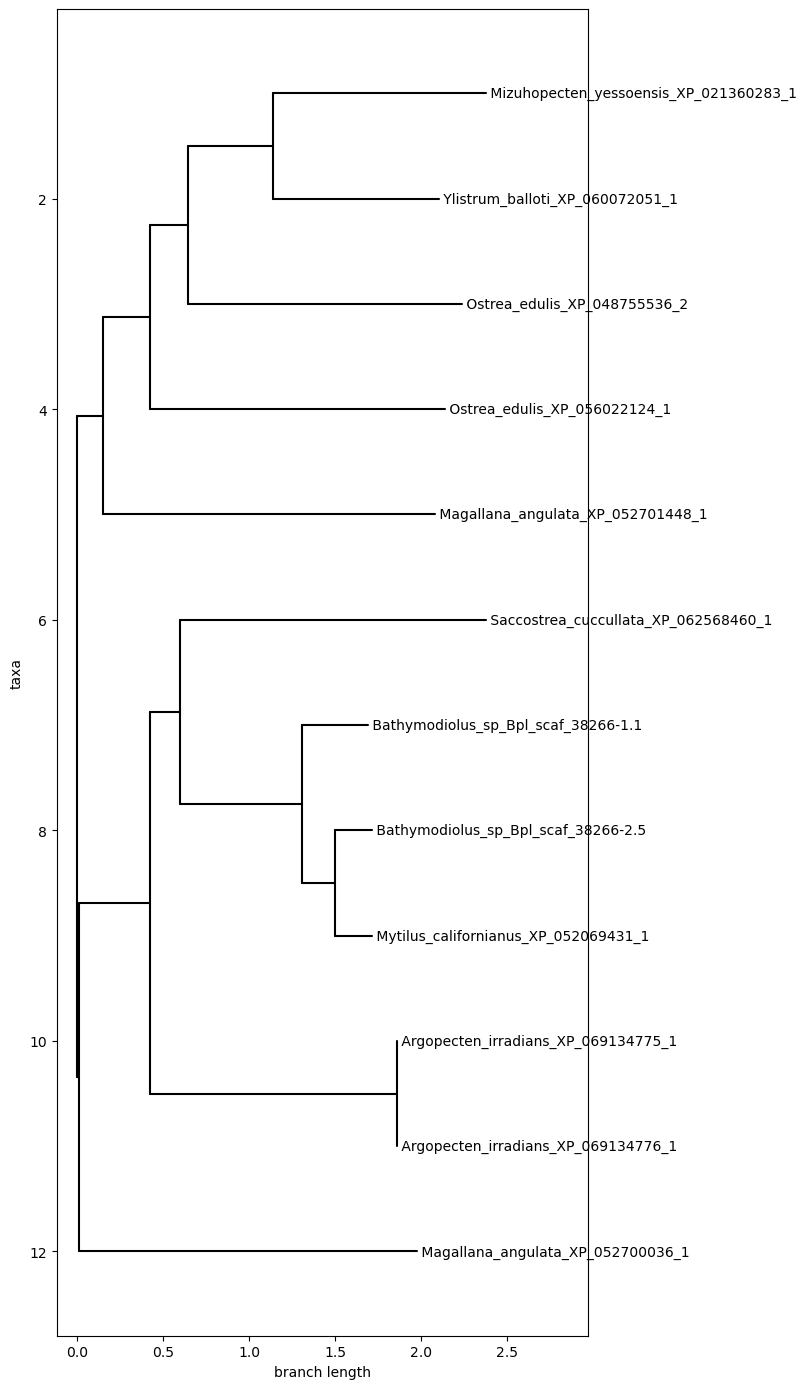

In [19]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Read the unrooted tree from IQ-TREE
tree = Phylo.read("bivalve_opsins_cleaned.treefile", "newick")

# Midpoint root
tree.root_at_midpoint()

# (Optional) save the rooted tree for later / for iTOL
Phylo.write(tree, "bivalve_opsins_cleaned_midpoint_rooted.treefile", "newick")

# Plot the midpoint-rooted tree
fig = plt.figure(figsize=(8, 14))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=ax, do_show=False)

plt.tight_layout()
plt.show()
